# Question 2: Training and using materials models
**2.1 data cleaning and splitting**

In a Materials informatics workflow you need to find and clean data, featurize the data, train models, and use models for some task. A few years ago, we put together a nice series of notebooks that describe this process for an example where we train heat capacity data as a function of temperature and composition and then use this model to predict heat capacity as a function of temperature for new materials. The best practices document is a great starting point for you and can be found here `https://github.com/anthony-wang/BestPractices`. I'd like you to go through a similar exercise as the best practices notebook but with a few changes. 

**<font color='teal'>a)</font>** First, you'll notice that the original notebooks used `pandas-profiling` but this has been deprecated and replaced by ydata-profiling. Try to get ydata-profiling to work and then use it to inspect your data. 

In [13]:
# It works but the widget it porduces is not scrollable 
# and my computer slows down like crazy

#from ydata_profiling import ProfileReport
#import pandas as pd

#df=pd.read_csv('svm_df_binaryDescriptors.csv')
#profile = ProfileReport(df, title="Profiling Report")
#profile.to_widgets()

# using the _atomic_environment_features_binary combined with the density data
# results in a lot of data that is strongly correlated and redundant

# This worked before I'm not sure why it is throwing an error now, must be a conflict, maybe from downloading UMAP in Q3



**<font color='teal'>b)</font>** Second, in the data-splitting notebook, you'll see how we came up with an elaborate way to make sure tha as we split the data, we made sure that all the values corresponding to a formula went to either test, val, or train but would never be randomly split across these groups. We were silly and didn't know about `GroupKFold` in teh scikit-learn library. (`https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html`) Redo the splitting process using this much simpler tool. 


In [14]:
#code goes here
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np
import sys
import os
from CBFV import composition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

filename = 'C:\cp_data_demo.csv'

df=pd.read_csv(filename)
rename_dict = {'CONDITION: Temperature (K)':'Temperature', 'PROPERTY: Heat Capacity (J/mol K)':'target', 'FORMULA':'formula'}
df = df.rename(columns=rename_dict)
df = df.dropna()
df = df.reset_index(drop=True)
#print(df)
nunique=df.nunique()
print(nunique)
unique_vals=pd.Series({c: df[c].unique() for c in df})

groups = df['formula'].unique()

train_groups,test_groups = train_test_split(groups, test_size=0.2, random_state=42)
train_df = df[df['formula'].isin(train_groups)]
test_df = df[df['formula'].isin(test_groups)]

formula         244
Temperature     237
target         3632
dtype: int64


**2.2 model training and hyper parameter tuning**

**<font color='teal'>c)</font>** Next, when we built our classic models, we never performed hyperparameter tuning! We just used them with default parameters. I'd like you to build two models and perform hyperparameter tuning on them. One model should be either `Ridge` or `Lasso` and the other should be `XGBoost`. Compare performance metrics including training time. 

In [15]:
# Featurize the data 

print(train_df)
print(test_df)

X_train_feats_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(train_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_feats_unscaled, y_test, formulae_train, skipped_train = composition.generate_features(test_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

#X_train_feats_unscaled.to_csv("X_train_feats_unscaled.csv")


     formula  Temperature   target
0       B2O3       1400.0  134.306
1       B2O3       1300.0  131.294
2       B2O3       1200.0  128.072
3       B2O3       1100.0  124.516
4       B2O3       1000.0  120.625
...      ...          ...      ...
4565     Zr1        500.0   26.564
4566     Zr1        450.0   26.246
4567     Zr1        400.0   25.935
4568     Zr1        350.0   25.606
4569     Zr1        298.0   25.202

[3589 rows x 3 columns]
     formula  Temperature  target
82     B2Mg1       1900.0  92.242
83     B2Mg1       1800.0  90.249
84     B2Mg1       1700.0  88.162
85     B2Mg1       1600.0  85.981
86     B2Mg1       1500.0  83.643
...      ...          ...     ...
4537      W1        450.0  25.144
4538      W1        400.0  24.928
4539      W1        350.0  24.644
4540      W1        300.0  24.313
4541      W1        298.0  24.295

[981 rows x 3 columns]


Processing Input Data:   0%|          | 0/3589 [00:00<?, ?it/s]

Processing Input Data: 100%|██████████| 3589/3589 [00:00<00:00, 5759.83it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 3589/3589 [00:01<00:00, 2326.03it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 981/981 [00:00<00:00, 2310.92it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 981/981 [00:00<00:00, 1716.94it/s]


	Creating Pandas Objects...


In [16]:
#X_train_feats_unscaled.to_csv("X_train_unscaled.csv")
print(y_train)

0       134.306
1       131.294
2       128.072
3       124.516
4       120.625
         ...   
3584     26.564
3585     26.246
3586     25.935
3587     25.606
3588     25.202
Name: target, Length: 3589, dtype: float64


In [17]:
df=pd.read_csv(filename)
rename_dict = {'CONDITION: Temperature (K)':'Temperature', 'PROPERTY: Heat Capacity (J/mol K)':'target', 'FORMULA':'formula'}
df = df.rename(columns=rename_dict)
df = df.dropna()

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_feats_unscaled)
X_test = scaler.transform(X_test_feats_unscaled)

# Normalize the data
X_train = normalize(X_train)
#X_val = normalize(X_val)
X_test = normalize(X_test)


the r2 score for ridge is 0.8618170004565164
the mean absolute error for ridge is 19.068023852734463
ridge score :  0.8618170004565164

the r2 score for new ridge is 0.858032544956445
the mean absolute error for new ridge is 19.014417682387595
new ridge score :  0.858032544956445


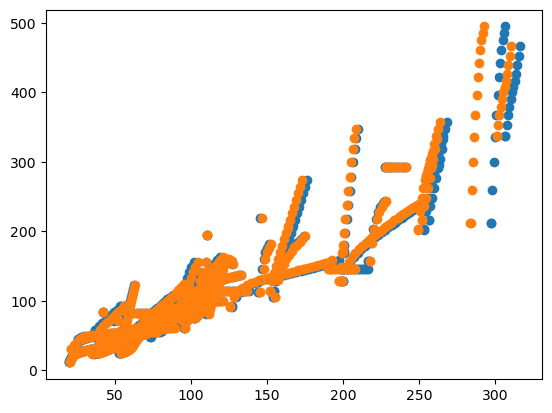

In [18]:
# Ridge
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#RNG_SEED = 42
#np.random.seed(seed=RNG_SEED)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RNG_SEED)
  
# training model with 0.5 alpha value 
ridge = Ridge(alpha = 0.5, tol = 0.001,
              solver ='auto', random_state = 42) 
ridge.fit(X_train, y_train) 
  
# predicting the y_test 
y_pred = ridge.predict(X_test) 
r2 = r2_score(y_test, y_pred)
print('the r2 score for ridge is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error for ridge is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)
  
# finding score for our model 
score = ridge.score(X_test, y_test) # model score is r^2 value
print("ridge score : ", score) 

# Perform hyperparameter tuning (in this case using grid search)
#ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]} # this is lambda which is a bias term
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}
new_ridge = GridSearchCV(Ridge(), param_grid=ridge_params).fit(X_train, y_train).best_estimator_


# predicting the y_test 
y_pred = new_ridge.predict(X_test) 
r2 = r2_score(y_test, y_pred)
print('\nthe r2 score for new ridge is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error for new ridge is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)
  
# finding score for our model 
score = new_ridge.score(X_test, y_test) # model score is r^2 value
print("new ridge score : ", score) 

c:\Miniconda3\envs\MatInformatics\lib\site-packages\xgboost\core.py:160: UserWarning: [16:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


the r2 score is 0.8953378306787365
the mean absolute error is 17.130460867544443


Model score :  0.8953378306787365


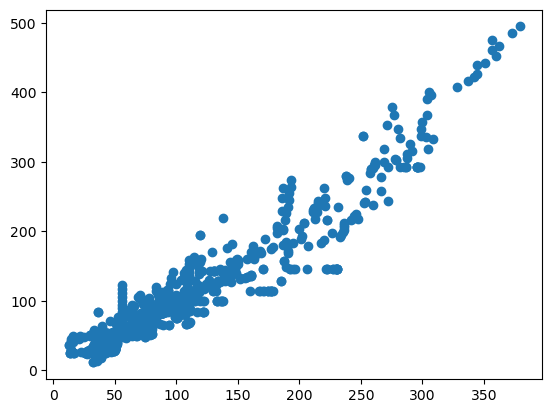

In [19]:
# XGBoost
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Use "hist" for training the model.
XGBoost = xgb.XGBRegressor(tree_method="hist", device="cuda")
# Fit the model using predictor X and response y.
XGBoost.fit(X_train, y_train)

y_pred=XGBoost.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('the r2 score is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)

score = XGBoost.score(X_test, y_test)
print("\n\nModel score : ", score)

# Save model into JSON format.
#reg.save_model("regressor.json")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Miniconda3\envs\MatInformatics\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
c:\Miniconda3\envs\MatInformatics\lib\site-packages\xgboost\core.py:160: UserWarning: [16:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


the r2 score is 0.8953378306787365
the mean absolute error is 17.130460867544443


Model score :  0.8953378306787365


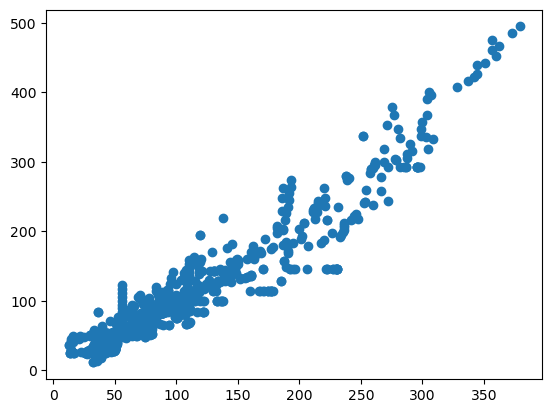

In [22]:
# Hyperparameter optimization on XGBoost
from sklearn.model_selection import RandomizedSearchCV

params = {
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]
}

# n_iter is number of iterations
# scoring is 
# n_jobs=-1 uses all the cores on my computer
# cv=5 is 5 fold cross validation
# verbose=3 gives the status of the fit
random_search = RandomizedSearchCV(XGBoost,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X_train,y_train)

y_pred=XGBoost.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('the r2 score is',r2)
mae = mean_absolute_error(y_test, y_pred)
print('the mean absolute error is',mae)
rmse_val = mean_squared_error(y_test, y_pred, squared=False)

plt.scatter(y_pred,y_test)

score = XGBoost.score(X_test, y_test)
print("\n\nModel score : ", score)



**2.3 using your model to make predictions**

**<font color='teal'>c)</font>** Finally, pick the best model from **2.2** and use it to predict the heat capacity from 1200K to 2000K for ZrN. See how it compares to experiment. 

![ZrN Cp](https://www.researchgate.net/publication/335403917/figure/fig2/AS:796198449467394@1566839911338/High-temperature-heat-capacity-Cp-of-zirconium-and-hafnium-carbides-and-carbonitrides.png)


Processing Input Data: 100%|██████████| 9/9 [00:00<00:00, 1493.17it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 9/9 [00:00<00:00, 769.33it/s]

	Creating Pandas Objects...


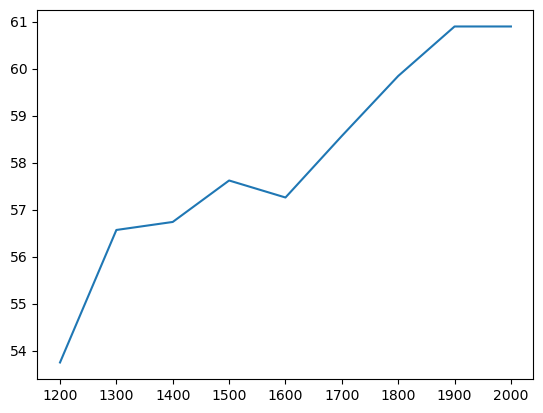

In [21]:

pred_data = {"formula":['ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN','ZrN'],"Temperature":[1200,1300,1400,1500,1600,1700,1800,1900,2000],'target':[0,0,0,0,0,0,0,0,0]}
pred_df = pd.DataFrame(data=pred_data)

X_pred_unscaled, y_pred, formulae_train, skipped_train = composition.generate_features(pred_df, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

# Scale the data
X_pred_unscaled = scaler.transform(X_pred_unscaled)
# Normalize the data
X_pred = normalize(X_pred_unscaled)

# XGBoost Model
y_pred=XGBoost.predict(X_pred)
plt.plot([1200,1300,1400,1500,1600,1700,1800,1900,2000],y_pred)
